<h1 style="text-align: center;">Benchmark Pandas vs Polar vs Dask</h1>


# Make dataFrame

In [1]:
import time

In [2]:
import numpy as np

M,N=10000000,5
arr = np.random.uniform(-1, 1, size=(M, N))
colsint= np.random.randint(0,100,(M,1))
arr2=np.concatenate((arr, colsint), axis=1).astype("float64")
print("shape",arr2.shape)
print(round((M*(N+1)*64/8)/(1024*1024), 1),"MB")

shape (10000000, 6)
457.8 MB


In [3]:
import pandas as pd
dfpd = pd.DataFrame(arr2, columns=["a","b","c","d","e","colint"])
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   a       float64
 1   b       float64
 2   c       float64
 3   d       float64
 4   e       float64
 5   colint  float64
dtypes: float64(6)
memory usage: 457.8 MB


In [4]:
dfpd.head()

,a,b,c,d,e,colint
0,-0.565588,0.188080,-0.604835,0.810952,0.020947,24.0
1,0.017615,-0.472792,-0.489760,-0.977290,-0.746440,35.0
2,-0.307249,-0.028380,0.066513,0.668759,-0.980749,98.0
3,0.817180,-0.350454,-0.585490,-0.794863,0.560024,98.0
4,-0.949001,0.448160,-0.234075,-0.908258,-0.733441,87.0


In [5]:
import dask.dataframe as dd
dfdd = dd.from_pandas(dfpd, npartitions=20)
dfdd.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 6 entries, a to colint
dtypes: float64(6)

In [6]:
dfdd.head()

,a,b,c,d,e,colint
0,-0.565588,0.188080,-0.604835,0.810952,0.020947,24.0
1,0.017615,-0.472792,-0.489760,-0.977290,-0.746440,35.0
2,-0.307249,-0.028380,0.066513,0.668759,-0.980749,98.0
3,0.817180,-0.350454,-0.585490,-0.794863,0.560024,98.0
4,-0.949001,0.448160,-0.234075,-0.908258,-0.733441,87.0


In [7]:
import polars as pl
dfpl = pl.DataFrame(dfpd)

In [8]:
dfpl.head()

a,b,c,d,e,colint
f64,f64,f64,f64,f64,f64
-0.565588,0.18808,-0.604835,0.810952,0.020947,24.0
0.017615,-0.472792,-0.48976,-0.97729,-0.74644,35.0
-0.307249,-0.02838,0.066513,0.668759,-0.980749,98.0
0.81718,-0.350454,-0.58549,-0.794863,0.560024,98.0
-0.949001,0.44816,-0.234075,-0.908258,-0.733441,87.0


# Benchmark

In [9]:
bench=[]

## Save load parquet

In [10]:
file_path = 'dfpd.parquet'


#### save 
start_time = time.time()

dfpd.to_parquet(file_path, engine='pyarrow') 

deltime = (time.time() - start_time)  * 1_000  #ms
res={
"what":"saveparquet",
"package":"pandas",
"time": deltime
}
bench.append(res)
print(res)

#### load 
start_time = time.time()

_ = pd.read_parquet(file_path, engine='pyarrow') 

deltime = (time.time() - start_time)  * 1_000  #ms
res={
"what":"loadparquet",
"package":"pandas",
"time": deltime
}
bench.append(res)
print(res)
# delte file 
import os 
del(_)
os.remove(file_path)

{'what': 'saveparquet', 'package': 'pandas', 'time': 5929.890871047974}
{'what': 'loadparquet', 'package': 'pandas', 'time': 968.9915180206299}


In [11]:
file_path = 'dfpl.parquet'

# Save
start_time = time.time()
dfpl.write_parquet(file_path)
deltime = (time.time() - start_time) * 1_000  # ms
res = {
    "what": "saveparquet",
    "package": "polars",
    "time": deltime
}
bench.append(res)
print(res)

# Load 
start_time = time.time()
_ = pl.read_parquet(file_path)
deltime = (time.time() - start_time) * 1_000  # ms
res = {
    "what": "loadparquet",
    "package": "polars",
    "time": deltime
}
bench.append(res)
print(res)

# Delete
del(_)
os.remove(file_path)

{'what': 'saveparquet', 'package': 'polars', 'time': 4887.706279754639}
{'what': 'loadparquet', 'package': 'polars', 'time': 897.2001075744629}


In [12]:
file_path = 'dfdd.parquet'

# Save 
start_time = time.time()
dfdd.to_parquet(file_path, engine='pyarrow')
deltime = (time.time() - start_time) * 1_000  # ms
res = {
    "what": "saveparquet",
    "package": "dask",
    "time": deltime
}
bench.append(res)
print(res)

# Load
start_time = time.time()
_ = dd.read_parquet(file_path, engine='pyarrow')
deltime = (time.time() - start_time) * 1_000  # ms
res = {
    "what": "loadparquet",
    "package": "dask",
    "time": deltime
}
bench.append(res)
print(res)

# Delete 
del(_)
import shutil
shutil.rmtree(file_path)

{'what': 'saveparquet', 'package': 'dask', 'time': 3198.096990585327}
{'what': 'loadparquet', 'package': 'dask', 'time': 57.28602409362793}


## Agg

In [13]:
start_time = time.time()

_= dfpd.sum()

deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"agg_sum",
"package":"pandas",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'agg_sum', 'package': 'pandas', 'time': 1372.3723888397217}


In [14]:
start_time = time.time()

_= dfdd.sum()

deltime = (time.time() - start_time)  * 1_000 #ms

res={
"what":"agg_sum",
"package":"dask",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'agg_sum', 'package': 'dask', 'time': 11.806011199951172}


In [15]:
start_time = time.time()

_= dfpl.sum()

deltime = (time.time() - start_time)  * 1_000 #ms

res={
"what":"agg_sum",
"package":"polars",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'agg_sum', 'package': 'polars', 'time': 26.842832565307617}


## Group By 

In [16]:
start_time = time.time()

dfpdgroupby = dfpd.groupby("colint").mean()

deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"groupby_mean",
"package":"pandas",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'groupby_mean', 'package': 'pandas', 'time': 1391.1476135253906}


In [17]:
start_time = time.time()

dfddgroupby = dfdd.groupby("colint").mean().compute()

deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"groupby_mean",
"package":"dask",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'groupby_mean', 'package': 'dask', 'time': 1011.9261741638184}


In [18]:
start_time = time.time()

dfplgroupby = dfpl.group_by("colint").mean()

deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"groupby_mean",
"package":"polars",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'groupby_mean', 'package': 'polars', 'time': 310.1382255554199}


## Sub df and sort values

In [19]:
start_time = time.time()

tab2= dfpd[["a","colint"]].rename(columns  ={"a":"a2"})
tab2["a2"]=tab2["a2"]*10
tab2pd = tab2.sort_values("a2")


deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"sort_values",
"package":"pandas",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'sort_values', 'package': 'pandas', 'time': 10040.702819824219}


In [20]:
start_time = time.time()

tab2= dfdd[["a","colint"]].rename(columns  ={"a":"a2"})
tab2["a2"]=tab2["a2"]*10
tab2dd = tab2.sort_values("a2")


deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"sort_values",
"package":"dask",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'sort_values', 'package': 'dask', 'time': 46.8592643737793}


In [21]:
start_time = time.time()


tab2= dfpl[["a","colint"]].rename({"a":"a2"})
tab2 = tab2.with_columns((tab2["a2"] * 10).alias("a2"))
tab2pl = tab2.sort("a2")


deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"sort_values",
"package":"polars",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'sort_values', 'package': 'polars', 'time': 1784.329891204834}


## Left join

**join vs merge in pandas** <br>
| Feature              | `merge()`                                | `join()`                               |
|----------------------|------------------------------------------|----------------------------------------|
| **Primary Use**       | Joins DataFrames based on columns.       | Joins DataFrames based on index or column. |
| **Join Keys**         | Can join on columns with different names (`left_on` and `right_on`). | Primarily uses indexes by default, but can join on columns if set as the index. |
| **Flexibility**       | More flexible with column-based joins, and supports multiple columns. | Simpler, mainly designed for index-based joins. |
| **Syntax Complexity** | More complex syntax with more options.   | Simpler, especially for index-based joins. |
| **Common Use Case**   | SQL-style joins where you specify columns explicitly. | Join DataFrames when you want to join based on index (or set a column as index). |


In [22]:
start_time = time.time()


dfpdjoin = dfpd.merge(dfpdgroupby , how="right", on="colint")


deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"left_join",
"package":"pandas",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'left_join', 'package': 'pandas', 'time': 4404.075384140015}


In [23]:
start_time = time.time()


dfddjoin = dfdd.merge(dfddgroupby , how="right", on="colint")


deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"left_join",
"package":"dask",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'left_join', 'package': 'dask', 'time': 27.34375}


In [24]:
start_time = time.time()


dfpljoin = dfpl.join(dfplgroupby , how="right", on="colint")



deltime = (time.time() - start_time)  * 1_000  #ms

res={
"what":"left_join",
"package":"polars",
"time": deltime
}

bench.append(res)
print(res)

{'what': 'left_join', 'package': 'polars', 'time': 783.4796905517578}


## Result

In [58]:
res = pd.DataFrame(bench)
res =res.sort_values("time")
res["sort1"]= res.package.map({'dask':3, 'polars':2, 'pandas':1})
#res=res.sort_values("sort1")

In [59]:
res.what.unique()

array(['agg_sum', 'left_join', 'sort_values', 'loadparquet',
       'groupby_mean', 'saveparquet'], dtype=object)

In [60]:
res["sort2"]=res.what.map({
    'agg_sum':2, 
    'left_join':5, 
    'sort_values':4, 
    'loadparquet':1,
    'groupby_mean':3, 
    'saveparquet':0})
res=res.sort_values(["sort2", "sort1"])

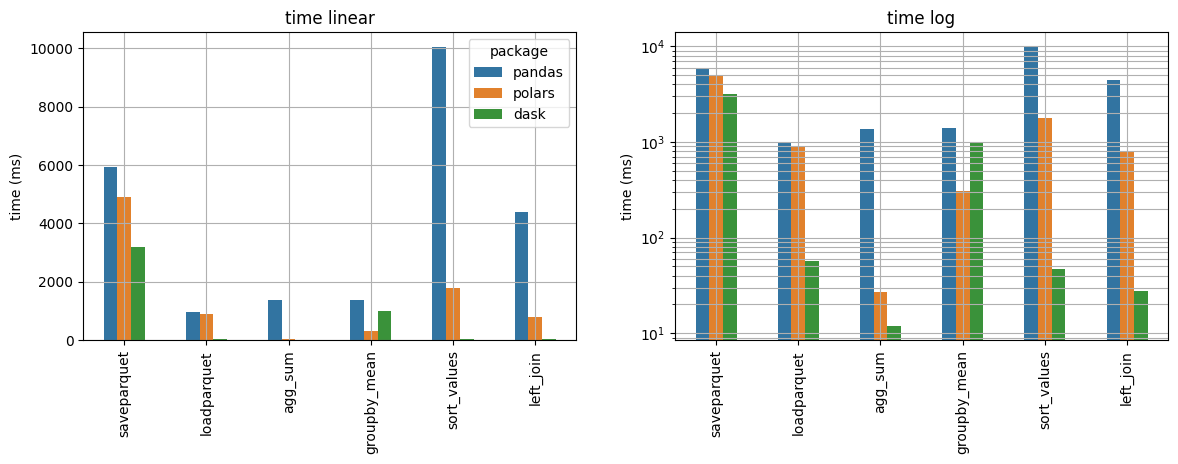

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(14,4))
sns.barplot(data= res, x= "what", y= "time", hue="package", width =0.5, ax= axs[0]) 
sns.barplot(data= res, x= "what", y= "time", hue="package", width =0.5, ax= axs[1]) 
axs[1].set_yscale("log")

axs[0].tick_params(axis="x", rotation=90)
axs[1].tick_params(axis="x", rotation=90)
axs[0].set_xlabel("")
axs[1].set_xlabel("")

axs[0].grid(which= "both") 
axs[1].grid(which= "both")
axs[0].set_title("time linear") 
axs[1].set_title("time log") 

axs[0].set_ylabel("time (ms)")
axs[1].set_ylabel("time (ms)")
axs[1].legend().remove()

plt.show()